## spark setup & libraries

In [4]:
# spark setup
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
from pyspark.ml.feature import MinHashLSH, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, when, explode, lit, array_contains
# from itertools import groupby
from pyspark.sql import Window
from pyspark.sql.functions import row_number, ceil, col, udf
import math

import networkx as nx
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from collections import defaultdict

# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# show all rows with df.head
pd.options.display.max_columns = None
# remove warnings
import warnings
warnings.filterwarnings('ignore')

## create spark session + load data

In [5]:
spark = SparkSession.builder \
  .appName("DIS_project_5") \
  .master("local[*]") \
  .config("spark.driver.memory", "10G") \
  .config("spa\rk.driver.maxResultSize", "40g") \
  .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
  .getOrCreate()
spark
sc = spark.sparkContext

In [6]:
json_file_path = "../Community Detection/10K.json"
with open(json_file_path, 'r') as f:
    community_data = json.load(f)

community_rdd = sc.parallelize(community_data)
print(community_rdd.take(3))
print(community_rdd.count())
print(type(community_rdd))

[{'community_id': 1, 'nodes': [371, 340, 378, 667, 974, 368, 627, 64, 168, 257, 925, 767, 549, 890, 899, 226, 45, 71, 72, 381, 707, 973, 812, 839, 96, 433, 670, 468, 466, 876, 402, 646, 593, 366, 612], 'edges': [{'node1': 371, 'node2': 549, 'begintijd': 20240318013535, 'eindtijd': 20240318030219}, {'node1': 371, 'node2': 812, 'begintijd': 20240412020025, 'eindtijd': 20240412053609}, {'node1': 371, 'node2': 670, 'begintijd': 20240606074446, 'eindtijd': 20240606110610}, {'node1': 340, 'node2': 378, 'begintijd': 20240918161950, 'eindtijd': 20240918172041}, {'node1': 378, 'node2': 466, 'begintijd': 20240918071254, 'eindtijd': 20240918140257}, {'node1': 667, 'node2': 767, 'begintijd': 20241101133614, 'eindtijd': 20241101175233}, {'node1': 368, 'node2': 627, 'begintijd': 20240112043512, 'eindtijd': 20240112122716}, {'node1': 368, 'node2': 767, 'begintijd': 20240205225900, 'eindtijd': 20240206062846}, {'node1': 64, 'node2': 627, 'begintijd': 20240407064043, 'eindtijd': 20240407074414}, {'node

## group communities

In [7]:
# turn rdd into dataframe and add columns for count of nodes and edges
df_community = spark.createDataFrame(community_rdd)
df_community.show()
# Add columns for node size and edge size
df_with_sizes = df_community \
    .withColumn("node_size", F.size("nodes")) \
    .withColumn("edge_size", F.size("edges")) \

df_with_sizes.show()

# group communities by number of nodes
# Group by node size
node_size_groups = df_with_sizes.groupBy("node_size").count()
node_size_groups.show()


# group communities by number of edges
# Group by edge size
edge_size_groups = df_with_sizes.groupBy("edge_size").count()
edge_size_groups.show()

+------------+--------------------+--------------------+
|community_id|               edges|               nodes|
+------------+--------------------+--------------------+
|           1|[{eindtijd -> 202...|[371, 340, 378, 6...|
|           2|[{eindtijd -> 202...|[419, 134, 779, 4...|
|           3|[{eindtijd -> 202...|[51, 411, 958, 98...|
|           4|[{eindtijd -> 202...|[87, 337, 351, 43...|
|           5|[{eindtijd -> 202...|[132, 290, 999, 4...|
|           6|[{eindtijd -> 202...|[759, 386, 483, 2...|
|           7|[{eindtijd -> 202...|[138, 398, 109, 4...|
|           8|[{eindtijd -> 202...|[204, 651, 618, 8...|
|           9|[{eindtijd -> 202...|[250, 298, 299, 1...|
|          10|[{eindtijd -> 202...|[451, 306, 543, 1...|
|          11|[{eindtijd -> 202...|[4, 577, 406, 900...|
|          12|[{eindtijd -> 202...|[797, 984, 476, 1...|
|          13|[{eindtijd -> 202...|[777, 567, 674, 9...|
|          14|[{eindtijd -> 202...|[305, 322, 86, 38...|
|          15|[{eindtijd -> 202

+---------+-----+
|node_size|count|
+---------+-----+
|       26|    3|
|       57|    1|
|       35|    1|
|       29|    1|
|       47|    1|
|       37|    1|
|       30|    1|
|       46|    2|
|       41|    1|
|       38|    1|
|       36|    1|
|       50|    1|
|       21|    2|
|        2|   23|
|       31|    2|
|        3|    5|
|       48|    1|
|       43|    1|
|       13|    1|
|        4|    2|
+---------+-----+
only showing top 20 rows

+---------+-----+
|edge_size|count|
+---------+-----+
|       28|    2|
|       26|    1|
|       35|    1|
|       58|    1|
|       48|    2|
|       39|    1|
|       49|    1|
|       29|    1|
|       41|    1|
|       37|    1|
|       38|    1|
|       53|    1|
|       47|    1|
|        1|   23|
|       20|    2|
|       31|    1|
|       44|    1|
|        2|    5|
|       12|    1|
|        3|    2|
+---------+-----+
only showing top 20 rows



### make N groups by size

In [8]:
# group communities by number of nodes and edges
def group_by_size(df, num_groups, column_name):
  # sort the data by the column name
  sorted_df = df.sort(column_name)

  # calculate the size of each group
  group_size = math.ceil(df.count() / num_groups)
  
  # add a row number column to the dataframe
  df_with_row_number = df.withColumn("row_number", row_number().over(Window.orderBy(column_name)))

  # use row number to create groups
  df_groups = df_with_row_number.withColumn("group", ceil(col("row_number") / group_size)).drop("row_number")

  return df_groups


result = group_by_size(df_with_sizes, 3, 'node_size')
result.show(55)

24/11/09 16:50:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------+--------------------+--------------------+---------+---------+-----+
|community_id|               edges|               nodes|node_size|edge_size|group|
+------------+--------------------+--------------------+---------+---------+-----+
|          16|[{eindtijd -> 202...|          [623, 936]|        2|        1|    1|
|          26|[{eindtijd -> 202...|           [24, 775]|        2|        1|    1|
|          30|[{eindtijd -> 202...|          [216, 710]|        2|        1|    1|
|          32|[{eindtijd -> 202...|          [740, 743]|        2|        1|    1|
|          33|[{eindtijd -> 202...|           [50, 749]|        2|        1|    1|
|          34|[{eindtijd -> 202...|          [193, 949]|        2|        1|    1|
|          35|[{eindtijd -> 202...|           [47, 620]|        2|        1|    1|
|          37|[{eindtijd -> 202...|          [150, 795]|        2|        1|    1|
|          38|[{eindtijd -> 202...|          [273, 976]|        2|        1|    1|
|   

In [9]:
# make unique pairs of communities in same group
def create_pairs_grouped_communities(df_groups):
  df_pairs = (
    df_groups.alias("df1")
    .join(df_groups.alias("df2"), (F.col("df1.group") == F.col("df2.group")) & (F.col("df1.community_id") < F.col("df2.community_id")))
    # .withColumn("pairs", (F.col("df1.community_id") + F.lit(", ") + F.col("df2.community_id")))
    .select(
      F.array(F.col("df1.community_id"), F.col("df2.community_id")).alias("pairs"),
      F.col("df1.group").alias("group"),
      F.col("df1.community_id").alias("community_id_1"),
      F.col("df2.community_id").alias("community_id_2"),
      F.col("df1.nodes").alias("nodes_1"),
      F.col("df2.nodes").alias("nodes_2"),
      F.col("df1.edges").alias("edges_1"),
      F.col("df2.edges").alias("edges_2"),
    )
  )

  return df_pairs

result_group_communities = create_pairs_grouped_communities(result)
result_group_communities.show()

24/11/09 16:50:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 1

+--------+-----+--------------+--------------+----------+----------+--------------------+--------------------+
|   pairs|group|community_id_1|community_id_2|   nodes_1|   nodes_2|             edges_1|             edges_2|
+--------+-----+--------------+--------------+----------+----------+--------------------+--------------------+
|[16, 26]|    1|            16|            26|[623, 936]| [24, 775]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|[16, 30]|    1|            16|            30|[623, 936]|[216, 710]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|[16, 32]|    1|            16|            32|[623, 936]|[740, 743]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|[16, 33]|    1|            16|            33|[623, 936]| [50, 749]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|[16, 34]|    1|            16|            34|[623, 936]|[193, 949]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|[16, 35]|    1|            16|            35|[623, 936]| [47, 620]|[{eindtijd -> 202...|[{eindtijd -> 202...|
|

In [10]:
# complete code to turn rdd of communities into dataframe of pairs of communities of similiar node or edge size
def rdd_community_to_dataframe_paired_community_by_column(rdd_communities, number_groups_of_communities_wanted, column_name):
  # turn rdd into dataframe and add columns for count of nodes and edges
  df_community = spark.createDataFrame(rdd_communities)
  df_with_sizes = df_community \
    .withColumn("node_size", F.size("nodes")) \
    .withColumn("edge_size", F.size("edges")) \

  # group communities by number of nodes and edges
  df_communities_groups = group_by_size(df_with_sizes, number_groups_of_communities_wanted, column_name)

  # make unique pairs of communities in same group
  result_grouped_communities = create_pairs_grouped_communities(df_communities_groups)

  # from this dataframe you can see which communities are grouped together, so all the pairs as a seperate column

  return result_grouped_communities


# example
#example_result = rdd_community_to_dataframe_paired_community_by_column(community_rdd, 3, 'node_size')
#example_result.show()

Adding similarity computations to code 

In [ ]:
#Creating Datafram of grouped communities
grouped_communities=rdd_community_to_dataframe_paired_community_by_column(community_rdd, 3, 'node_size')

#Converting it to RDD
pairs_rdd = grouped_communities.rdd
type(pairs_rdd)

24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 16:50:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/11/09 1

pyspark.rdd.RDD

In [12]:
###TemporalNetSimile defintion
"""
Temporalnetsimile.py
--------------

Graph distance based on:
Berlingerio, M., Koutra, D., Eliassi-Rad, T. & Faloutsos, C. NetSimile: A Scalable Approach to Size-Independent Network Similarity. arXiv (2012)

Extended upon netsimile.py, acreditted to:

author: Alex Gates
email: ajgates42@gmail.com (optional)
Submitted as part of the 2019 NetSI Collabathon.
https://netrd.readthedocs.io/en/latest/_modules/netrd/distance/netsimile.html

We wish to note that extensions upon the initial netsimile code is preceded by a ###comment

"""

import networkx as nx
import numpy as np
from scipy.spatial.distance import canberra
from scipy.stats import skew, kurtosis

from netrd.distance.base import BaseDistance
from netrd.utilities import undirected, unweighted

###Needed to convert time later
from datetime import datetime


class TemporalNetSimile(BaseDistance):
    """Compares node signature distributions."""


    @undirected
    @unweighted
    def dist(self, G1, G2):
        """A scalable approach to network similarity.

        A network similarity measure based on node signature distributions.
        
        The results dictionary includes the underlying feature matrices in
        `'feature_matrices'` and the underlying signature vectors in
        `'signature_vectors'`.

        Parameters
        ----------

        G1, G2 (nx.Graph)
            two undirected networkx graphs to be compared.

        Returns
        -------

        dist (float)
            the distance between `G1` and `G2`.

        References
        ----------

        .. [1] Michele Berlingerio, Danai Koutra, Tina Eliassi-Rad,
               Christos Faloutsos: NetSimile: A Scalable Approach to
               Size-Independent Network Similarity. CoRR abs/1209.2684
               (2012)

        """

        # find the graph node feature matrices
        G1_node_features = feature_extraction(G1)
        G2_node_features = feature_extraction(G2)

        # get the graph signature vectors
        G1_signature = graph_signature(G1_node_features)
        G2_signature = graph_signature(G2_node_features)

        # the final distance is the absolute canberra distance
        dist = abs(canberra(G1_signature, G2_signature))

        ###Remove for quicker comp.
        ###self.results['feature_matrices'] = G1_node_features, G2_node_features
        ###self.results['signature_vectors'] = G1_signature, G2_signature
        
        self.results['dist'] = dist

        return dist



def feature_extraction(G):
    """Node feature extraction.

    Parameters
    ----------

    G (nx.Graph): a networkx graph.

    Returns
    -------

    node_features (float): the Nx7 matrix of node features."""

    # necessary data structures
    ###FEATURE NUMBER
    node_features = np.zeros(shape=(G.number_of_nodes(), 10)) 
    node_list = sorted(G.nodes())
    node_degree_dict = dict(G.degree())
    node_clustering_dict = dict(nx.clustering(G))
    egonets = {n: nx.ego_graph(G, n) for n in node_list}

    # node degrees
    degs = [node_degree_dict[n] for n in node_list]

    # clustering coefficient
    clusts = [node_clustering_dict[n] for n in node_list]

    # average degree of neighborhood
    neighbor_degs = [
        np.mean([node_degree_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # average clustering coefficient of neighborhood
    neighbor_clusts = [
        np.mean([node_clustering_dict[m] for m in egonets[n].nodes if m != n])
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    # number of edges in the neighborhood
    neighbor_edges = [
        egonets[n].number_of_edges() if node_degree_dict[n] > 0 else 0
        for n in node_list
    ]

    # number of outgoing edges from the neighborhood
    # the sum of neighborhood degrees = 2*(internal edges) + external edges
    # node_features[:,5] = node_features[:,0] * node_features[:,2] - 2*node_features[:,4]
    neighbor_outgoing_edges = [
        len(
            [
                edge
                for edge in set.union(*[set(G.edges(j)) for j in egonets[i].nodes])
                if not egonets[i].has_edge(*edge)
            ]
        )
        for i in node_list
    ]

    # number of neighbors of neighbors (not in neighborhood)
    neighbors_of_neighbors = [
        len(
            set([p for m in G.neighbors(n) for p in G.neighbors(m)])
            - set(G.neighbors(n))
            - set([n])
        )
        if node_degree_dict[n] > 0
        else 0
        for n in node_list
    ]

    ###Temporal features on the edges

    ###start time, average start time of the edges of a single node
    ###Loop over all nodes, look at the starttime data from the edges, convert the time to time format, calculate mean start time for each node
    startTime = []
    for n in node_list:
        start_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            start_time_str = str(data['begintijd'])
            start_time = datetime.strptime(start_time_str, '%Y%m%d%H%M%S')
            start_times.append(start_time.timestamp())  # Store as timestamp (seconds since epoch)

        startTime.append(np.mean(start_times) if start_times else 0)

    ###end time, average end time of the edges of a single node
    ###Loop over all nodes, look at the endtime data from the edges, convert the time to time format, calculate mean end time for each node
    endTime = []
    for n in node_list:
        end_times = []
        for u, v, data in G.edges(n, data=True):
            # Convert begintijd to a datetime object
            end_time_str = str(data['eindtijd'])
            end_time = datetime.strptime(end_time_str, '%Y%m%d%H%M%S')
            end_times.append(end_time.timestamp())  # Store as timestamp (seconds since epoch)

        endTime.append(np.mean(end_times) if end_times else 0)
    
    ###duration, average duration of the edges of a single node
    duration = []
    for n in node_list:
        duration.append(endTime[node_list.index(n)] - startTime[node_list.index(n)])
    ### end change

    # assembling the features
    node_features[:, 0] = degs
    node_features[:, 1] = clusts
    node_features[:, 2] = neighbor_degs
    node_features[:, 3] = neighbor_clusts
    node_features[:, 4] = neighbor_edges
    node_features[:, 5] = neighbor_outgoing_edges
    node_features[:, 6] = neighbors_of_neighbors

    ###Time features
    node_features[:, 7] = startTime
    node_features[:, 8] = endTime
    node_features[:, 9] = duration

    return np.nan_to_num(node_features)


def graph_signature(node_features):
    ###FEATURE NUMBER
    signature_vec = np.zeros(10 * 5)

    # for each of the features
    ### FEATURE NUMBER
    for k in range(10):
        # find the mean
        signature_vec[k * 5] = node_features[:, k].mean()
        # find the median
        signature_vec[k * 5 + 1] = np.median(node_features[:, k])
        # find the std
        signature_vec[k * 5 + 2] = node_features[:, k].std()
        # find the skew
        signature_vec[k * 5 + 3] = skew(node_features[:, k])
        # find the kurtosis
        signature_vec[k * 5 + 4] = kurtosis(node_features[:, k])

    return signature_vec


"""
# sample usage
>>>G1 = nx.karate_club_graph()
>>>G2 = nx.krackhardt_kite_graph()

>>>test = TemporalNetSimile()
>>>print(test.dist(G1, G2))
11.45
"""

'\n# sample usage\n>>>G1 = nx.karate_club_graph()\n>>>G2 = nx.krackhardt_kite_graph()\n\n>>>test = TemporalNetSimile()\n>>>print(test.dist(G1, G2))\n11.45\n'

In [13]:

#Based on outcome of above, this is rough sketch of how I would envision it
# Get data from two communities
def Compare(Community1, Community2):
    #Convert into networkX graph to use as input for TemportalNetSimile
    #Load Graphs
    Graph1 = nx.Graph()
    Graph1.add_nodes_from(Community1["nodes"])

    # Add edges with timestamps as edge attributes
    for edge in Community1["edges"]:
        Graph1.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    Graph2=nx.Graph()
    Graph2.add_nodes_from(Community2["nodes"])
    for edge in Community2["edges"]:
        Graph2.add_edge(edge["node1"], edge["node2"], begintijd=edge["begintijd"], eindtijd=edge["eindtijd"])

    testTime=TemporalNetSimile()
    Similarity = testTime.dist(Graph1, Graph2)
    return(Similarity)

#print(Compare(Community1,Community2))

In [14]:
# Step 2: Define a function to compute similarity
def compute_similarity(row):
    # Extract community data from the row
    community1 = {
        'community_id': row['community_id_1'],
        'nodes': row['nodes_1'],
        'edges': row['edges_1']
    }
    community2 = {
        'community_id': row['community_id_2'],
        'nodes': row['nodes_2'],
        'edges': row['edges_2']
    }
    group = row['group']

    # Compute the distance using the Compare function
    distance = Compare(community1, community2)

    # Return a tuple: (group, community_id1, community_id2, distance)
    return (group, community1['community_id'], community2['community_id'], distance)


In [15]:
# Step 3: Apply the function to each row in the RDD
similarities_rdd = pairs_rdd.map(compute_similarity)

# Step 4: Collect the results
similarities = similarities_rdd.collect()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [19]:
# Organize similarities by group
group_similarities = defaultdict(list)
for group, community_id1, community_id2, distance in similarities:
    group_similarities[group].append((community_id1, community_id2, distance))

print(group_similarities)

defaultdict(<class 'list'>, {1: [(16, 26, 1.350733253217603), (16, 30, 1.5750811226772958), (16, 32, 1.1583021061907512), (16, 33, 1.538107964596007), (16, 34, 1.6033209368490837), (16, 35, 0.6838316328514601), (16, 37, 1.3606400088282269), (16, 38, 0.5286257610466362), (16, 39, 1.2358982526419127), (16, 40, 1.6335701386879296), (16, 41, 0.6126299631549049), (16, 42, 0.6511343401861547), (16, 44, 1.1261544856712775), (16, 45, 1.37106742157421), (16, 46, 1.42506686509344), (16, 47, 1.6226723738898599), (16, 48, 0.8488470241153204), (26, 30, 0.4530613546316454), (26, 32, 0.33016224609172967), (26, 33, 0.38984543885348066), (26, 34, 0.5489366618933694), (26, 35, 0.8736306439112894), (26, 37, 0.01986676352467536), (26, 38, 1.0381345283352768), (26, 39, 0.24708933329812405), (26, 40, 0.6192360851180917), (26, 41, 1.632386927619647), (26, 42, 0.9125290968162618), (26, 44, 0.37228346544601104), (26, 45, 0.025674249841848188), (26, 46, 0.14547216656740108), (26, 47, 0.5998820706336546), (26, 4

In [ ]:
import numpy as np
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster

for group, group_sims in group_similarities.items():
    # Get the set of unique community IDs in the group
    community_ids = set()
    for community_id1, community_id2, _ in group_sims:
        community_ids.add(community_id1)
        community_ids.add(community_id2)
    community_ids = sorted(community_ids)
    id_to_index = {community_id: idx for idx, community_id in enumerate(community_ids)}
    N = len(community_ids)
    
    # Initialize a full distance matrix with zeros or a large number for missing values
    distance_matrix = np.full((N, N), np.inf)
    np.fill_diagonal(distance_matrix, 0)  # Distance to self is zero

    # Fill in the distances
    for community_id1, community_id2, distance in group_sims:
        i = id_to_index[community_id1]
        j = id_to_index[community_id2]
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # Symmetric matrix
    
    # Convert to condensed distance matrix required by linkage function
    condensed_dists = squareform(distance_matrix)

    # Apply hierarchical clustering
    Z = linkage(condensed_dists, method='average')  # You can try other methods like 'single', 'complete', etc.

    # Choose a threshold or number of clusters
    
    distances = [distance for _, _, distance in group_sims]
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    std_distance = np.std(distances)
    print(f"Group {group} - Mean: {mean_distance}, Median: {median_distance}, Std: {std_distance}")

    threshold = mean_distance - std_distance
    print(f"Group {group} - Threshold: {threshold}")
    # Adjust based on your analysis for this group
    # Option 2: Specify the number of clusters
    # num_clusters = 3  # Adjust based on desired number of clusters

    # Get cluster labels
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')
    # cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')

    # Group communities by cluster labels
    clusters = defaultdict(list)
    for community_id, cluster_label in zip(community_ids, cluster_labels):
        clusters[cluster_label].append(community_id)
    
    # Output the clusters for this group
    print(f"\nGroup {group} Clustering Results:")
    for cluster_label, community_list in clusters.items():
        print(f"  Cluster {cluster_label}: {sorted(community_list)}")


Group 1 - Mean: 0.798011021386889, Median: 0.7429627719793517, Std: 0.4868317914624913
Group 1 - Threshold: 0.31117922992439767

Group 1 Clustering Results:
  Cluster 5: [16]
  Cluster 3: [26, 37, 45, 46]
  Cluster 1: [30, 33, 34, 40, 47]
  Cluster 2: [32, 39, 44]
  Cluster 4: [35, 38, 42, 48]
  Cluster 6: [41]
Group 2 - Mean: 18.4285054334939, Median: 18.71001838173932, Std: 8.895261687917563
Group 2 - Threshold: 9.533243745576337

Group 2 Clustering Results:
  Cluster 3: [2]
  Cluster 7: [10]
  Cluster 2: [15, 22, 27]
  Cluster 5: [20, 25, 29, 36, 43]
  Cluster 4: [21]
  Cluster 6: [28, 31]
  Cluster 1: [49, 50, 51, 52, 53]
Group 3 - Mean: 9.489516809169414, Median: 9.581327874444879, Std: 1.752323821894963
Group 3 - Threshold: 7.737192987274451

Group 3 Clustering Results:
  Cluster 2: [1, 6, 9, 18]
  Cluster 5: [3]
  Cluster 6: [4, 11, 19]
  Cluster 3: [5]
  Cluster 4: [7, 8]
  Cluster 1: [12, 13, 14]
  Cluster 8: [17]
  Cluster 7: [23]
  Cluster 9: [24]


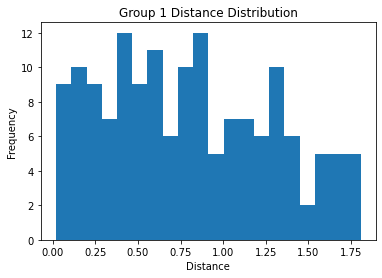

Group 1 - Mean: 0.798011021386889, Median: 0.7429627719793517, Std: 0.4868317914624913


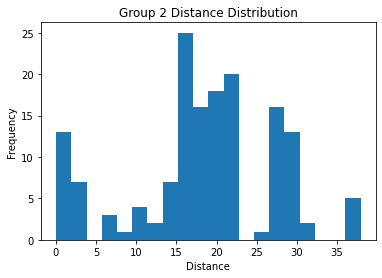

Group 2 - Mean: 18.4285054334939, Median: 18.71001838173932, Std: 8.895261687917563


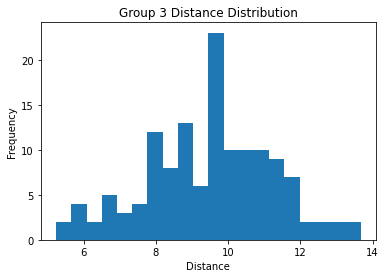

Group 3 - Mean: 9.489516809169414, Median: 9.581327874444879, Std: 1.752323821894963


In [18]:
import matplotlib.pyplot as plt

for group, group_sims in group_similarities.items():
    # Extract distances
    distances = [distance for _, _, distance in group_sims]
    
    # Plot histogram of distances for the group
    plt.figure()
    plt.hist(distances, bins=20)
    plt.title(f'Group {group} Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()
    
    # Calculate statistical measures
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)
    std_distance = np.std(distances)
    print(f"Group {group} - Mean: {mean_distance}, Median: {median_distance}, Std: {std_distance}")
    
    # Set threshold based on analysis
    # For example, threshold = median_distance + std_distance
    threshold = median_distance + std_distance
    # Proceed with clustering as in previous step using this threshold
